In [2]:
import numpy as np
from skimage.util import invert
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

from chromemt_analysis import parse_simulation_zip, segment_like_paper, continuous_erosion_iterative, linear_fit_to_residual_volume

In [3]:
regular_zip = '/Users/david/Downloads/VoxelTestReg.zip'
irregular_zip = '/Users/david/Downloads/VoxelTest.zip'

psz, mask_regular = parse_simulation_zip(regular_zip)
_, mask_irregular = parse_simulation_zip(irregular_zip)

# float and invert
mask_regular = mask_regular.astype(np.float32)
mask_regular = invert(mask_regular)
mask_irregular = mask_irregular.astype(np.float32)
mask_irregular = invert(mask_irregular)

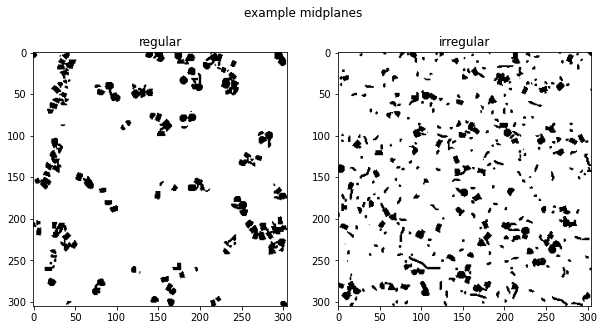

In [14]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

axs[0].imshow(mask_regular[mask_regular.shape[0]//2], cmap='gray')
axs[0].set_title('regular')
axs[1].imshow(mask_irregular[mask_irregular.shape[0]//2], cmap='gray')
axs[1].set_title('irregular')
fig.suptitle('example midplanes');

In [4]:
# CVC from raw masks
invert(mask_regular).sum() / mask_regular.size, invert(mask_irregular).sum() / mask_irregular.size

(0.09270671994572233, 0.13155451777902116)

In [5]:
# try segmentation on raw masks
seg_noblur_regular = segment_like_paper(mask_regular)
seg_noblur_irregular = segment_like_paper(mask_irregular)

In [6]:
# CVC from segs
seg_noblur_regular.sum() / seg_noblur_regular.size, seg_noblur_irregular.sum() / seg_noblur_irregular.size 

(0.08814076949171958, 0.10796907230120582)

In [7]:
# blur simulations
sigmas = np.linspace(0.5, 10, 10)

blurred_regular = {s: gaussian_filter(mask_regular, s) for s in sigmas}
blurred_irregular = {s: gaussian_filter(mask_irregular, s) for s in sigmas}

In [8]:
# segment blurs
segmentations_regular = {s: segment_like_paper(b) for s,b in blurred_regular.items()}
segmentations_irregular = {s: segment_like_paper(b) for s,b in blurred_irregular.items()}

In [9]:
# cvcs from blurred images
cvcs_regular = {s: seg.sum() / seg.size for s, seg in segmentations_regular.items()}
cvcs_irregular = {s: seg.sum() / seg.size for s, seg in segmentations_irregular.items()}
cvcs_regular, cvcs_irregular

({0.5: 0.08808878276155273,
  1.5555555555555556: 0.11968656407364493,
  2.611111111111111: 0.17008443878562524,
  3.666666666666667: 0.21470787422735824,
  4.722222222222222: 0.2548307391367559,
  5.777777777777778: 0.2887929474273177,
  6.833333333333334: 0.31573081447345813,
  7.888888888888889: 0.3361968446698182,
  8.944444444444445: 0.35164102722254287,
  10.0: 0.36274775421731337},
 {0.5: 0.10795056854979052,
  1.5555555555555556: 0.2360963428657024,
  2.611111111111111: 0.3100311656041695,
  3.666666666666667: 0.3400321260369811,
  4.722222222222222: 0.35213245161489287,
  5.777777777777778: 0.358799688079619,
  6.833333333333334: 0.3675453716390359,
  7.888888888888889: 0.37348133984782866,
  8.944444444444445: 0.3767202012503249,
  10.0: 0.37865407236729065})

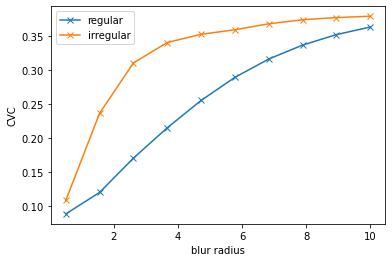

In [ ]:
# CVC vs. blur plot

plt.plot(*zip(*cvcs_regular.items()), '-x', label='regular')
plt.plot(*zip(*cvcs_irregular.items()), '-x', label='irregular')
plt.xlabel('blur radius')
plt.ylabel('CVC')
plt.legend()

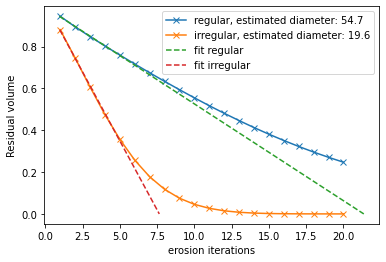

In [97]:
# diameter estimation on unblurred masks

erosion_radii = np.arange(1, 21)
trace_regular = continuous_erosion_iterative(mask_regular.astype(bool), n_iterations=20, connectivity=1)
trace_irregular = continuous_erosion_iterative(mask_irregular.astype(bool), n_iterations=20, connectivity=1)

d_regular, lm_regular = linear_fit_to_residual_volume(trace_regular, erosion_radii)
d_irregular, lm_irregular = linear_fit_to_residual_volume(trace_irregular, erosion_radii)

plt.plot(erosion_radii, trace_regular, '-x', label='regular, estimated diameter: {:.1f}'.format(d_regular * psz))
plt.plot(erosion_radii, trace_irregular, '-x', label='irregular, estimated diameter: {:.1f}'.format(d_irregular * psz))

plt.plot(lm_regular.predict(np.linspace(trace_regular[0],0).reshape(-1,1)), np.linspace(trace_regular[0],0).reshape(-1,1), '--', label='fit regular')
plt.plot(lm_irregular.predict(np.linspace(trace_irregular[0],0).reshape(-1,1)), np.linspace(trace_irregular[0],0).reshape(-1,1), '--', label='fit irregular')

plt.xlabel('erosion iterations')
plt.ylabel('Residual volume')
plt.legend()

In [93]:
# estimated diameters from blurred
erosion_radii = np.arange(1, 21)

traces_regular = {s: continuous_erosion_iterative(b, len(erosion_radii), 1) for s,b in segmentations_regular.items()}
traces_irregular = {s: continuous_erosion_iterative(b, len(erosion_radii), 1) for s,b in segmentations_irregular.items()}

diameters_regular = {s: linear_fit_to_residual_volume(t, erosion_radii)[0] * psz for s,t in traces_regular.items()}
diameters_irregular = {s: linear_fit_to_residual_volume(t, erosion_radii)[0] * psz for s,t in traces_irregular.items()}

diameters_regular, diameters_irregular

({0.5: 10.631694824986711,
  1.5555555555555556: 12.57953859839667,
  2.611111111111111: 16.289116880499755,
  3.666666666666667: 20.012806967921232,
  4.722222222222222: 23.55295125031409,
  5.777777777777778: 26.773105619565996,
  6.833333333333334: 29.77975982931155,
  7.888888888888889: 32.516282766550525,
  8.944444444444445: 34.978712715419185,
  10.0: 37.39478123256569},
 {0.5: 10.09592896850999,
  1.5555555555555556: 11.516249406545565,
  2.611111111111111: 13.787903313552466,
  3.666666666666667: 16.05264810213456,
  4.722222222222222: 18.003940119739234,
  5.777777777777778: 20.272658262518945,
  6.833333333333334: 22.846220134968707,
  7.888888888888889: 25.53509571825589,
  8.944444444444445: 28.21552672427444,
  10.0: 30.77621455587301})

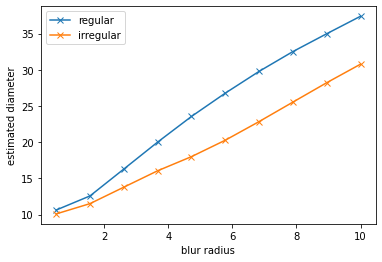

In [95]:
plt.plot(*zip(*diameters_regular.items()), '-x', label='regular')
plt.plot(*zip(*diameters_irregular.items()), '-x', label='irregular')
plt.xlabel('blur radius')
plt.ylabel('estimated diameter')
plt.legend()

Text(0.5, 1.0, 'continuous erosion, irregular')

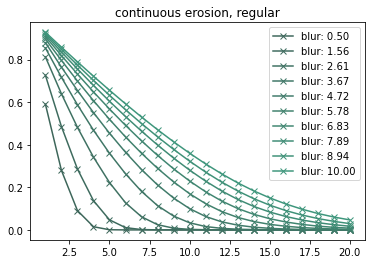

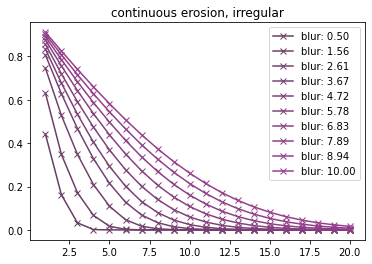

In [96]:
from matplotlib.colors import hsv_to_rgb

h = [0.45]

for (s, tr), sv in zip(traces_regular.items(), np.linspace(0.4, 0.8, len(trace_regular))):
    plt.plot(erosion_radii, tr, '-x', color=hsv_to_rgb(h + [sv] * 2), label='blur: {:.2f}'.format(s))
plt.legend()
plt.title('continuous erosion, regular')


h = [0.85]

plt.figure()
for (s, tr), sv in zip(traces_irregular.items(), np.linspace(0.4, 0.8, len(trace_irregular))):
    plt.plot(erosion_radii, tr, '-x', color=hsv_to_rgb(h + [sv] * 2), label='blur: {:.2f}'.format(s))
plt.legend()
plt.title('continuous erosion, irregular')


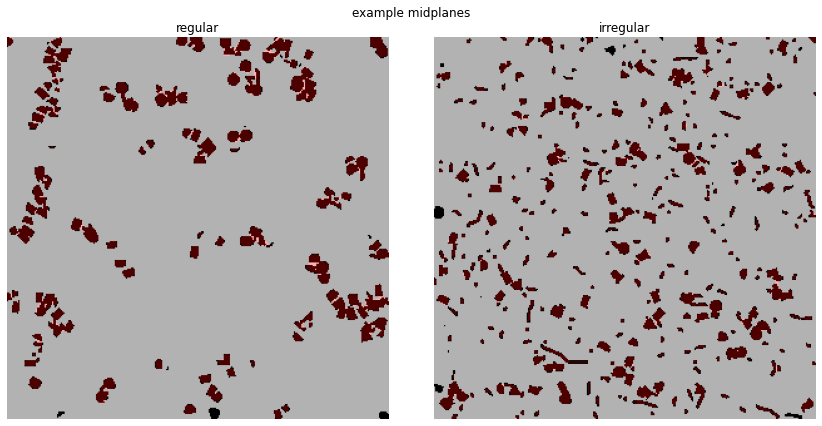

In [46]:
# plot examples, raw mask and segmentation 

from skimage.color import label2rgb, gray2rgb

overlay_regular = label2rgb(seg_noblur_regular[seg_noblur_regular.shape[0]//2], mask_regular[mask_regular.shape[0]//2], bg_label=0)
overlay_irregular = label2rgb(seg_noblur_irregular[seg_noblur_irregular.shape[0]//2], mask_irregular[mask_irregular.shape[0]//2], bg_label=0)

fig, axs = plt.subplots(ncols=2, figsize=(12,6))
axs[0].imshow(overlay_regular)
axs[0].set_title('regular')
axs[0].axis('off')
axs[1].imshow(overlay_irregular)
axs[1].set_title('irregular')
axs[1].axis('off')
fig.suptitle('example midplanes');
fig.tight_layout()

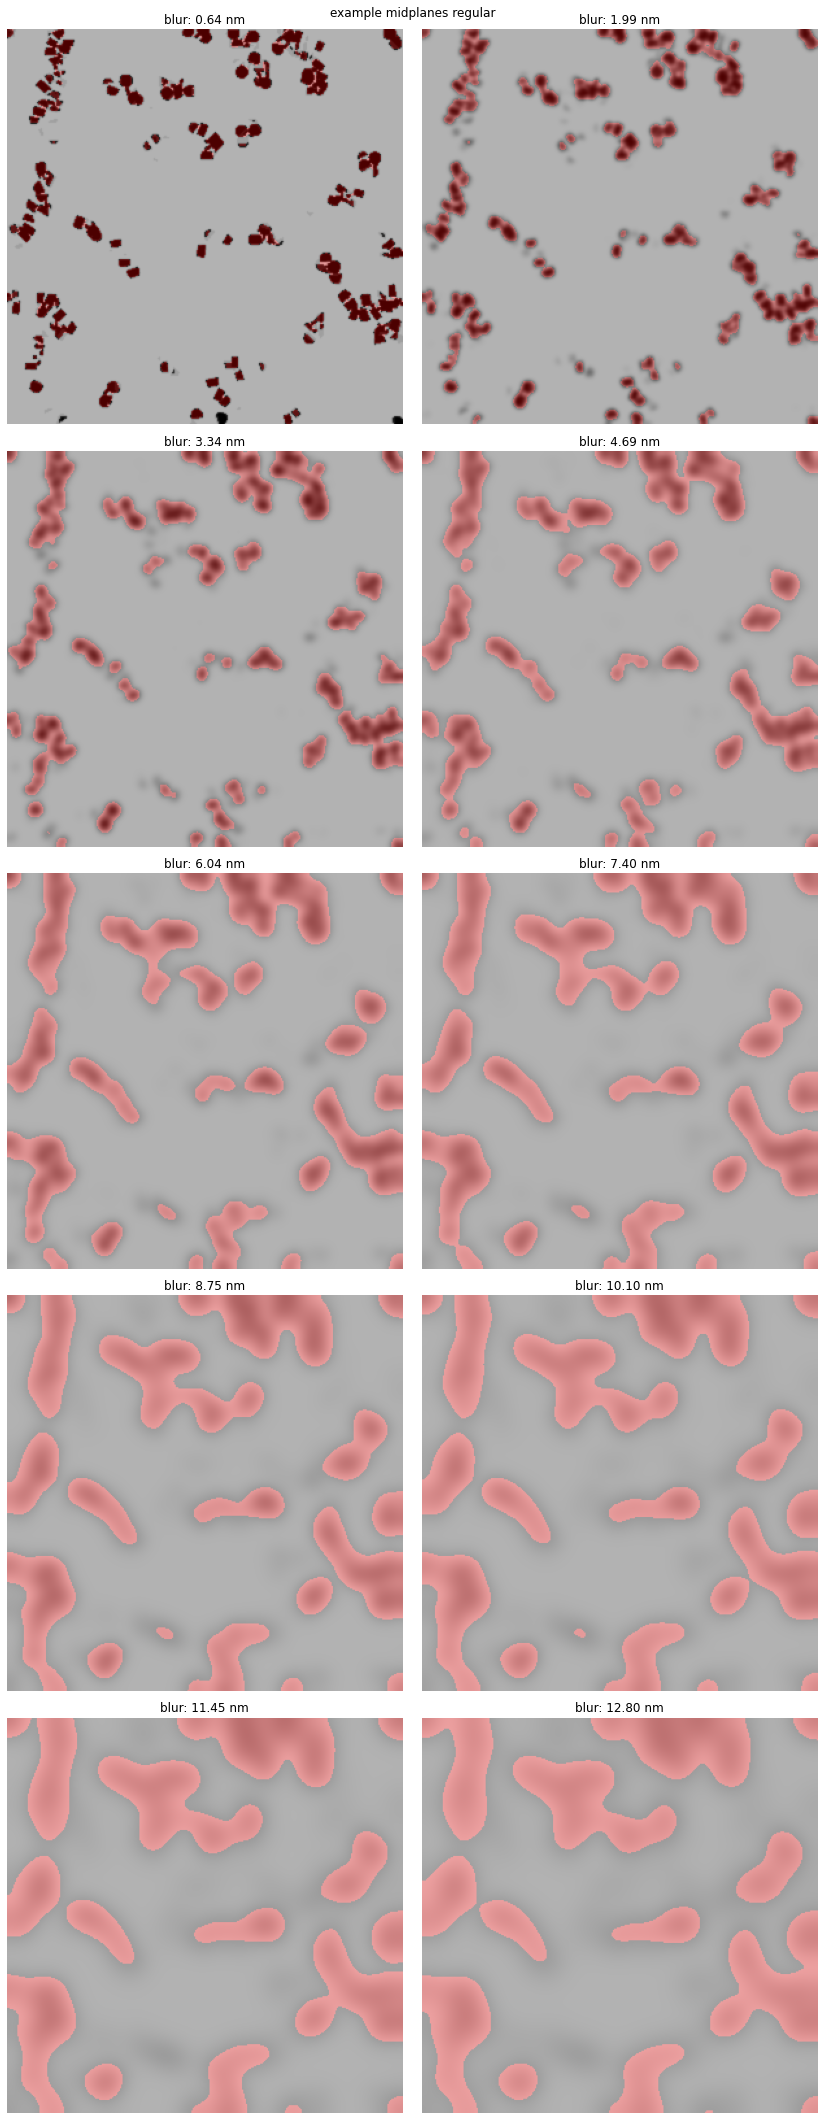

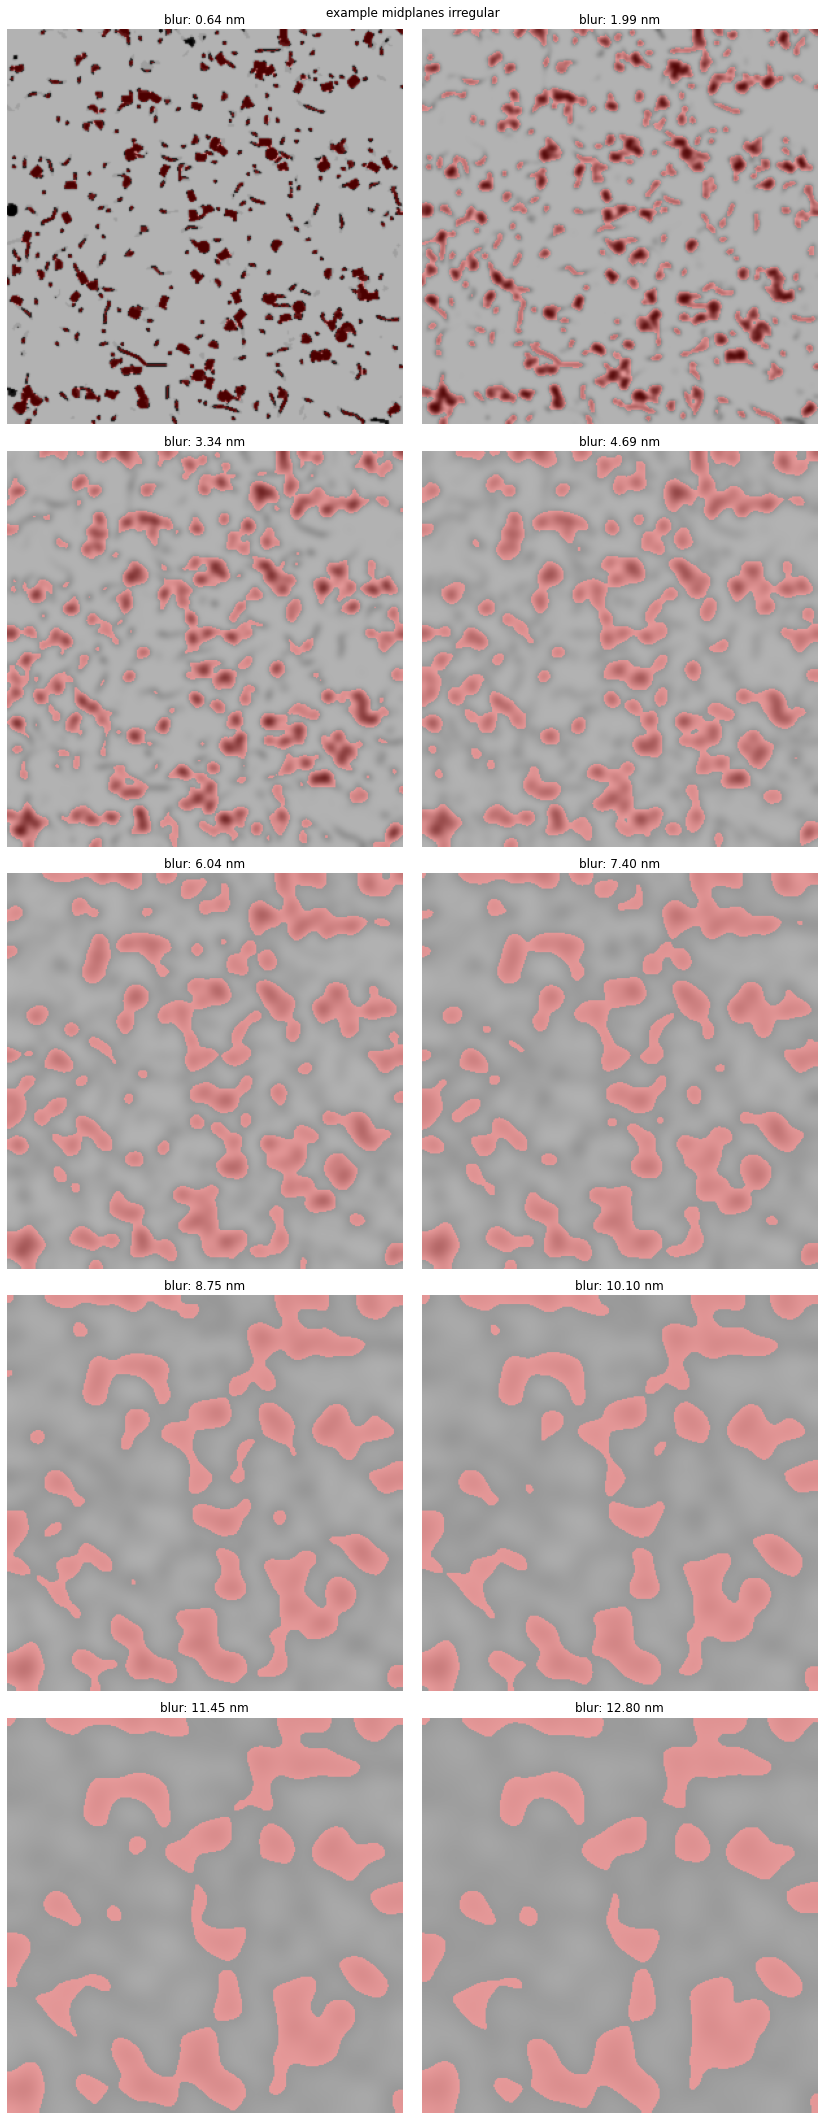

In [61]:
fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(12,30))
for ax, (s, b), (_, m) in zip(axs.flat, blurred_regular.items(), segmentations_regular.items()):
    overlay = label2rgb(m[m.shape[0]//2], b[b.shape[0]//2], bg_label=0)
    ax.imshow(overlay)
    ax.set_title('blur: {:.2f} nm'.format(s * psz))
    ax.axis('off')
fig.suptitle('example midplanes regular\n');
fig.tight_layout()


fig, axs = plt.subplots(ncols=2, nrows=5, figsize=(12,30))
for ax, (s, b), (_, m) in zip(axs.flat, blurred_irregular.items(), segmentations_irregular.items()):
    overlay = label2rgb(m[m.shape[0]//2], b[b.shape[0]//2], bg_label=0)
    ax.imshow(overlay)
    ax.set_title('blur: {:.2f} nm'.format(s * psz))
    ax.axis('off')
fig.suptitle('example midplanes irregular\n');
fig.tight_layout()
